In [1]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

In [2]:
class ReplayBuffer:
    ''' 经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)  # 队列,先进先出

    def add(self, state, action, reward, next_state, done):  # 将数据加入buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)

In [3]:
class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        # fc(x) = Wx + b
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim) # 输入state_dim维度，输出hidden_dim维度
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim) # 输入hidden_dim维度，输出action_dim维度

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        return self.fc2(x)

假设：  
	•	state_dim = 2  
	•	hidden_dim = 4  
	•	action_dim = 3  

那：  
	•	fc1 是 2 → 4 的线性层  
	•	fc2 是 4 → 3 的线性层  

假设你喂进去的是 3 个状态：  

states = tensor([  
    [0.1, 0.5],  
    [0.3, 0.2],  
    [0.9, 0.8],  
])  # shape: [3, 2]  

经过 fc1 → ReLU → fc2 后，就变成：

output = tensor([  
    [Q(s1,a1), Q(s1,a2), Q(s1,a3)],  
    [Q(s2,a1), Q(s2,a2), Q(s2,a3)],  
    [Q(s3,a1), Q(s3,a2), Q(s3,a3)],  
])  # shape: [3, 3]

这就是每个状态下的动作价值函数输出。  


q_net(states) 就是把状态输入进神经网络，输出该状态下 每个可能动作的 Q 值（向量），形状是 [batch_size, action_dim]，用于 DQN 的核心更新。这个输出里，还没挑动作，挑动作是在 .gather() 那一步做的。

In [4]:
'''
	•	self.q_net 和 self.target_q_net 是两套参数不同的网络；
	•	update() 中使用的是目标网络生成 TD 目标，训练的是 q_net；
	•	gather(1, actions) 是为了取出对应动作的 Q 值；
	•	max(1)[0] 是取出每个状态的最大 Q 值（即最大动作值）；
	•	target_update 是稳定训练的关键，防止目标也随着训练而剧烈变化。
'''
class DQN:
    ''' DQN算法 '''

    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, device):
        self.action_dim = action_dim  # 动作空间维度
        self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)  # 当前Q网络（用于选动作和训练）
        self.target_q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)  # 目标Q网络（用于估算TD目标）
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)  # 优化器
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # ε-贪婪策略探索率
        self.target_update = target_update  # 每隔多少步更新一次目标网络
        self.count = 0  # 步数计数器，用于控制目标网络的更新频率
        self.device = device  # 使用的计算设备（CPU 或 GPU）

    def take_action(self, state):
        ''' ε-贪婪策略：根据当前策略选择动作 '''
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)  # 以 ε 的概率随机选动作（探索）
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)  # 转为张量并送入设备
            action = self.q_net(state).argmax().item()  # 以 1 - ε 的概率选择最大Q值对应动作（利用）
        return action

    def update(self, transition_dict):
        ''' 用经验字典更新Q网络 '''
        # 将经验字典中的内容转换为张量
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        # 计算 Q(s, a)，.gather(dim, index) 就是 沿着 dim（1为行） 维度，根据 index 挑值。
        q_values = self.q_net(states).gather(1, actions)

        # 用目标网络计算 max_a' Q(s', a')
        '''
        .max(1)[0]  每行的最大值（即：每个 state 的最大 Q 值）
        .max(1)[1]  每行最大值对应的索引（即：最佳动作的编号）
        '''
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1) # 挑出最大Q值，然后用view(-1, 1) 变成 [batch_size, 1]

        # 构造TD目标值 y = r + γ * max_a' Q(s', a')
        # (1 - dones) 是为了在构造 TD 目标值 y = r + γ * max_a' Q(s', a') 时，屏蔽掉终止状态（terminal state）下的未来回报项。
        # 只在非终止状态下添加未来回报 γ × max Q(s′, a′)，否则只保留当前奖励 r。
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)

        # 均方误差损失函数：L = (Q(s,a) - y)^2
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))

        # 反向传播更新Q网络参数
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        # 每隔 target_update 步，同步一次目标网络参数
        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())

        self.count += 1  # 计数器+1

In [11]:
lr = 2e-3  # 学习率
num_episodes = 500  # 总训练轮数
hidden_dim = 128  # Q网络隐藏层维度
gamma = 0.98  # 折扣因子
epsilon = 0.01  # ε-贪婪策略参数
target_update = 10  # 目标网络同步频率
buffer_size = 10000  # 经验回放容量
minimal_size = 500  # 最小经验数量（小于这个值不更新网络）
batch_size = 64  # 每次采样batch大小
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name)

# 设置随机种子，确保结果可复现
random.seed(0)
np.random.seed(0)
env.reset(seed=0)  # Gym >= 0.26 新接口
torch.manual_seed(0)

# 初始化经验回放池、智能体
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]  # 状态维度（CartPole是4维）
action_dim = env.action_space.n  # 动作维度（CartPole是2维）
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device)

return_list = []  # 记录每个 episode 的回报
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc=f'Iteration {i}') as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state, _ = env.reset()  # 新版本 Gym 的 reset 返回 (obs, info)
            done = False
            while not done:
                action = agent.take_action(state)  # ε-贪婪策略选动作
                # Gym 新版将 done 拆成两个标志：
                # •	terminated: 正常完成（如 pole 倒下）
                # •	truncated: 超时等外部中止
                next_state, reward, terminated, truncated, _ = env.step(action) # 与环境交互，得到下一个状态、奖励，以及是否终止的两个标志
                done = terminated or truncated  # 两个结束条件都需判断
                replay_buffer.add(state, action, reward, next_state, done) # 将当前交互结果（s, a, r, s’, done）存入经验池中
                state = next_state
                episode_return += reward

                # 当经验数量超过阈值时，开始训练 Q 网络
                # 只有经验回放池（replay buffer）中存入超过 500 条交互记录之后，update() 才会被触发
                if replay_buffer.size() > minimal_size:
                    # 从经验池中随机抽取 batch_size=64 条经验（每条包含 state、action、reward、next_state、done）。
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size) 
                    # 把这 64 条经验转换成字典，方便 DQN 更新时使用。
                    transition_dict = {
                        'states': b_s, # batch_size, state_dim ；状态（state）是一个 4 维向量，如state = [位置x, 速度v, 杆角θ, 角速度ω]
                        'actions': b_a, # batch_size, 1 ；动作（action）是一个标量，如action = 0 或 1
                        'rewards': b_r, # batch_size, 1 ；奖励（reward）是一个标量，如reward = 1
                        'next_states': b_ns, # batch_size, state_dim ；下一个状态（next_state）是一个 4 维向量，如next_state = [位置x, 速度v, 杆角θ, 角速度ω]
                        'dones': b_d # batch_size, 1 ；是否终止（done）是一个标量，如done = 0 或 1
                    }
                    # print(transition_dict)
                    # 把这 64 条经验输入到 DQN 中，进行 一次反向传播 + 参数更新。
                    agent.update(transition_dict)
            
            return_list.append(episode_return) # 采样一个 batch 的数据进行 DQN 更新

            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode': f'{num_episodes / 10 * i + i_episode + 1}',
                    'return': f'{np.mean(return_list[-10:]):.3f}'
                })
            pbar.update(1)

Iteration 9: 100%|██████████| 50/50 [00:07<00:00,  6.48it/s, episode=500.0, return=373.700]


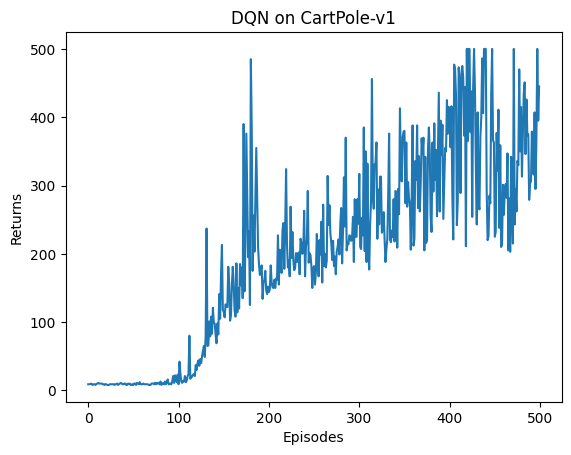

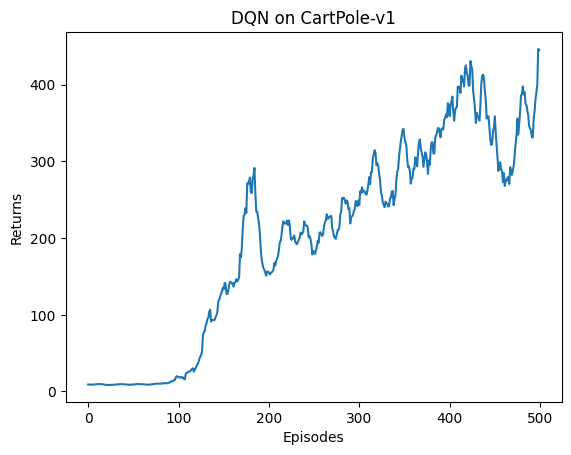

In [12]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

'''
	•	rl_utils.moving_average(...)：对回报曲线做滑动平均（如9个点做一次平均）
	•	目的是消除随机波动，看出整体趋势
	•	平滑后的曲线能更准确反映训练效果
'''
mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()